# Bayesian temp-Scaling

In [1]:
import os
import sys
import time

import torch
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.stats import entropy, gaussian_kde
from torch.nn.functional import softmax as torch_softmax

from adaptive_tempscaling.models import TempScaling
from adaptive_tempscaling.bnn_models import BNN_GVILR
from adaptive_tempscaling.bayesian_models import BayesianTempScaling_N
from adaptive_tempscaling.utils import load_precomputedlogits, compare_results, mutual_info

In [2]:
from adaptive_tempscaling.pyro_models import TempScaling

In [3]:
mcmc_TS = TempScaling()

In [6]:
mcmc_TS.fit(X_val=X_val, Y_val=Y_val)

Warmup:   0%|          | 0/1000 [00:00, ?it/s]

Sample: 100%|██████████| 1000/1000 [00:02, 389.72it/s, step size=1.01e+00, acc. prob=0.909]


In [7]:
mcmc_TS.predict(X_test=X_test)

tensor([[[ 18.4347,  -3.3207,  -2.3731,  ...,   0.2000,   2.6378,   0.9901],
         [ 18.9018,  -3.7993,  -4.3016,  ...,  -4.4236,  -1.0662,   2.9224],
         [ 15.3536,  -2.8766,  -0.3278,  ...,  -1.5241,  -1.6105,  -3.2617],
         ...,
         [-10.7779,  -3.0752,   0.5788,  ...,   0.1008,   6.7268,  20.4930],
         [-12.4479,  -3.3781,  -4.6270,  ...,  -1.5091,  11.4214,  27.0742],
         [ -9.7249,  -2.5535,  -0.8377,  ...,  -1.3883,  11.4015,  22.2479]]])

In [9]:
mcmc_TS.predictive

{'obs': tensor([[  0,   0,   0,  ..., 195, 195, 195],
         [  0,   0,   0,  ..., 195, 195, 195],
         [  0,   0,   0,  ..., 195, 195, 195],
         ...,
         [  0,   0,   0,  ..., 195, 195, 195],
         [  0,   0,   0,  ..., 195, 195, 195],
         [  0,   0,   0,  ..., 195, 195, 195]]),
 'calibrated_logits': tensor([[[[ 18.4192,  -3.3179,  -2.3711,  ...,   0.1998,   2.6355,   0.9892],
           [ 18.8858,  -3.7961,  -4.2980,  ...,  -4.4199,  -1.0653,   2.9199],
           [ 15.3406,  -2.8742,  -0.3276,  ...,  -1.5228,  -1.6091,  -3.2590],
           ...,
           [-10.7688,  -3.0726,   0.5783,  ...,   0.1007,   6.7211,  20.4757],
           [-12.4374,  -3.3752,  -4.6231,  ...,  -1.5078,  11.4117,  27.0513],
           [ -9.7167,  -2.5514,  -0.8370,  ...,  -1.3871,  11.3918,  22.2292]]],
 
 
         [[[ 18.7654,  -3.3803,  -2.4156,  ...,   0.2036,   2.6851,   1.0078],
           [ 19.2408,  -3.8674,  -4.3788,  ...,  -4.5030,  -1.0853,   2.9748],
           [ 15.6290

In [17]:
import pyro

import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.infer import MCMC, NUTS, Predictive

In [4]:
DATASET = 'cars'
MODEL = 'resnet-18'
dev = torch.device('mps')

In [5]:
train, validation, test = load_precomputedlogits(dataset=DATASET, model=MODEL, data_path='../../data', to_tensor=True)

X_train, Y_train = train
X_val, Y_val = validation
X_test, Y_test = test

N, dim = X_train.shape

In [8]:
def mcmc_TS(logits, targets):
    invT = pyro.sample("invT", dist.LogNormal(0, 0.25))

    calibrated_logits = logits * invT
    with pyro.plate('data', len(logits)):
        return pyro.sample("obs", dist.Categorical(logits=calibrated_logits), obs=targets)



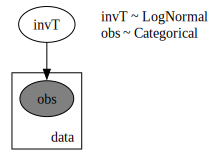

In [9]:
pyro.render_model(mcmc_TS, model_args=(X_val, Y_val), render_distributions=True)

In [11]:
nuts_kernel = NUTS(mcmc_TS)
mcmc = MCMC(nuts_kernel, num_samples=500)

In [13]:
mcmc.run(X_val, Y_val);

Sample: 100%|██████████| 1000/1000 [00:03, 302.41it/s, step size=1.06e+00, acc. prob=0.915]


In [24]:
samples = mcmc.get_samples()
posterior_T = samples['invT']**(-1)

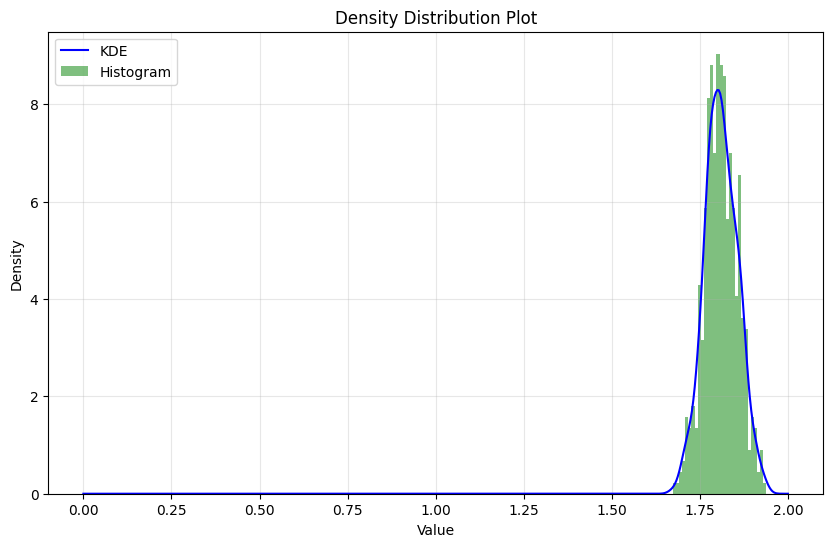

In [28]:
data = posterior_T.detach().numpy().flatten()

# Calculate the kernel density estimation
kde = gaussian_kde(data)
x_range = np.linspace(0, 2, 500)
y_values = kde(x_range)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_range, y_values, 'b-', label='KDE')
plt.hist(data, bins=30, density=True, alpha=0.5, color='g', label='Histogram')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Distribution Plot')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

In [18]:
predictive = Predictive(mcmc_TS, samples)(X_test, None)
for k, v in predictive.items():
    print(f"{k}: {tuple(v.shape)}")

obs: (500, 6081)


In [21]:
predictive['obs'][:, 1]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,